## Assignment 1 

In [1]:
import os
import sys
import glob
from urllib.request import urlretrieve
import requests
import json
import geopandas
import pandas as pd
import io
import numpy as np
from shapely.geometry import Point

%matplotlib inline

In [2]:
# Exit if PUIDATA is not set. Otherwise, print the value.
puidata = os.getenv("PUIDATA")
if puidata is None:
    print("You must set the PUIDATA environment variable.")
    sys.exit(1)
else:
    print("PUIDATA=%s" % puidata)

PUIDATA=/nfshome/aaw329/PUIdata


### Acquire Public Use Microdata Areas (PUMAs) from NYC Open Data

In [3]:
# Export the data as a shapefile
puma_url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
filename = "hw7_puma_aaw329.zip"
file_path = puidata + "/" + filename
data_dir = puidata + "/" + "hw7_puma_aaw329"

if not os.path.isfile(file_path):
    print("Downloading data...")
    urlretrieve(puma_url, file_path)

if not os.path.isfile(file_path):
    print("Problem acquiring data!")
    
if not os.path.isdir(data_dir):
    print("Creating directory to unzip to.")
    os.system("mkdir -p " + data_dir)
    print("Unzipping data...")
    os.system("unzip -d " + data_dir + " " + file_path)

In [4]:
# Get path to shapefile
puma_shapefile = glob.glob(data_dir + "/*.shp")
if len(puma_shapefile) != 1: 
    print("More than (or less than) one shapefile found!")
    sys.exit(1)
puma_shapefile = puma_shapefile[0]

### Create a GeoDataFrame from the downloaded data

In [5]:
gdf = geopandas.GeoDataFrame.from_file(puma_shapefile)

In [6]:
gdf.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [7]:
gdf.crs

{'init': 'epsg:4326'}

### Plot it

Text(0.5,1,'NYC PUMAs')

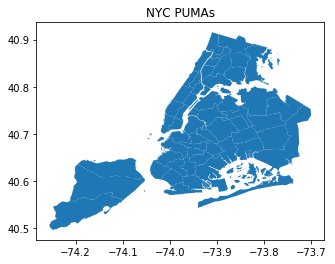

In [8]:
axes = gdf.plot()
axes.set_title("NYC PUMAs")

#### Figure 1: This plot shows the geographic areas of Public Use Microdata Areas (PUMAs) in NYC

### Get broadband data via the American Fact Finder (AFF) API

In [9]:
# URL containing possible features available from the American Community Survey (ACS) API
acs_url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
response = requests.request("GET", acs_url)

In [10]:
aff = json.loads(response.text)
aff_keys = list(aff["variables"].keys())

# Find all keys that begin with "B28002" and have "Broadband" in their label
[(key, aff["variables"][key]["label"]) for key in aff_keys if key.startswith("B28002") 
 and "Broadband" in aff["variables"][key]["label"]]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [11]:
num_households_key = "B28002_001E"  # Total number of households queried
aff["variables"][num_households_key]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [12]:
num_bb_households_key = "B28002_004E"  # Total number of households with broadband of any type
aff["variables"][num_bb_households_key]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [13]:
# Read in the census API key from a file called ".census_api_key" in $HOME
homedir = os.getenv("HOME")
with open(homedir + "/.census_api_key") as key_file:
    census_api_key = key_file.readline().strip()  # Read the first line of the file, and remove any whitespace
# Don't print the API key!
if census_api_key is None:
    print("Problem reading API key from ~/.census_api_key")
    sys.exit(1)

In [14]:
# Get the number of households queried from the API
acs_url = ("https://api.census.gov/data/2016/acs/acs1?get=" + num_households_key +
           ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + census_api_key
          )
response = requests.request("GET", acs_url).content
puma_num_households = pd.read_csv(io.StringIO(response.decode("utf-8").replace('[','').replace(']','')))
puma_num_households.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [15]:
# Get the number of households with broadband from the API
acs_url = ("https://api.census.gov/data/2016/acs/acs1?get=" + num_bb_households_key +
           ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + census_api_key
          )
response = requests.request("GET", acs_url).content
puma_num_broadband = pd.read_csv(io.StringIO(response.decode("utf-8").replace('[','').replace(']','')))
puma_num_broadband.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [16]:
# Merge the two datasets and create a column called "percent_bb" containing the percentage of households 
# with broadband for each PUMA
puma_bb = puma_num_households.merge(puma_num_broadband)
puma_bb["percent_bb"] = puma_bb[num_bb_households_key] / puma_bb[num_households_key] * 100.0
puma_bb.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4,B28002_004E,percent_bb
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,78.150656


In [17]:
# Read in percents downloaded manually from AFF (https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml)
bbpc_filename = "ACS_16_1YR_GCT2801.ST50_with_ann.csv"
broadband_percent = pd.read_csv(puidata + "/" + bbpc_filename, 
                                usecols=["GCT_STUB.target-geo-id2","HC01","HC02"],
                                skiprows=[1]  # Use this to skip the extra header that's in the dataset
                               )
broadband_percent.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [18]:
# Rename the GCT_STUB.target-geo-id2 column with a friendlier name
broadband_percent = broadband_percent.rename(index=str, columns={"GCT_STUB.target-geo-id2": "gid"})

In [19]:
# Select all the New York rows
broadband_percent = broadband_percent[(broadband_percent.gid > 3600000) & (broadband_percent.gid < 3605000)]
# Try to convert the "gid" column to contain the same values as our previous DataFrame, so we can merge them 
broadband_percent["gid"] = broadband_percent.gid - 3600000

In [20]:
diff = puma_bb.merge(broadband_percent, right_on="gid", left_on="public use microdata area")[["percent_bb", "HC01"]]
diff["diff"] = np.abs(diff["percent_bb"] - diff["HC01"].astype(float))

In [21]:
diff.describe()

,percent_bb,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


### Plot a choropleth of NYC broadband access

In [22]:
# Drop columns that we're not going to use
puma_bb.drop(puma_bb.columns.difference(["percent_bb","public use microdata area"]), 1, inplace=True)
puma_bb = puma_bb.rename(index=str, columns={"public use microdata area": "puma"})
puma_bb.head()

,puma,percent_bb
0,100,80.552879
1,200,75.733321
2,300,79.842678
3,401,81.433409
4,402,78.150656


In [23]:
# Make sure that the columns we're merging on are of the same datatype
gdf["puma_int"] = gdf.puma.astype("int64")
gdf = gdf.merge(puma_bb, left_on="puma_int", right_on="puma")

Text(0.5,1,'Percentage of households with broadband, by NYC PUMA')

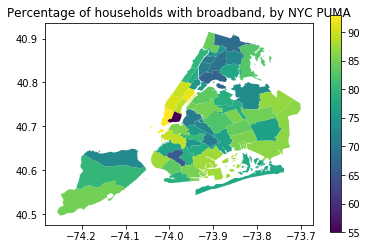

In [24]:
axes = gdf.plot(column="percent_bb", legend=True)
axes.set_title("Percentage of households with broadband, by NYC PUMA")

#### Figure 2: This choropleth shows the geographic areas of Public Use Microdata Areas (PUMAs) in NYC, colored by percentage of households that have broadband

### Assess whether LinkNYC are appropriately placed, where they can be used by people without broadband

In [25]:
linknyc_url = "https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv"
linknyc = pd.read_csv(linknyc_url)
linknyc.drop(linknyc.columns[0], axis=1, inplace=True)

In [26]:
linknyc.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [27]:
linknyc.shape

(1414, 4)

In [28]:
linknyc["lonlat"] = list(zip(linknyc.longitude, linknyc.latitude))
linknyc["geometry"] = linknyc["lonlat"].apply(lambda x: Point(x))
linknyc = geopandas.GeoDataFrame(linknyc)

In [29]:
linknyc.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [30]:
# Make sure we're using the same CRS as for the previous choropleth
linknyc.crs = {'init' :'epsg:4326'}

Text(0.5,1,'LinkNYC locations overlayed with broadband access')

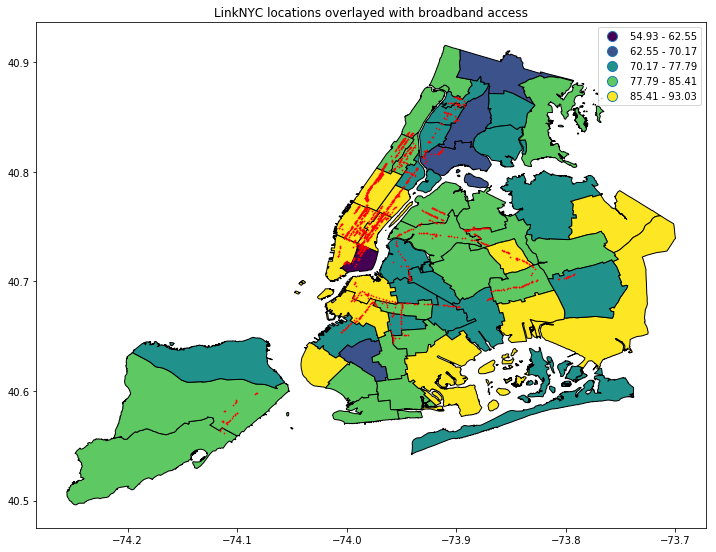

In [31]:
# Create an overlay of the choropleth (this time with 5 equal intervals instead of the gradient like before)
# and LinkNYC locations
base = gdf.plot(column="percent_bb", scheme="Equal_interval", k=5, legend=True, figsize=(12,12), edgecolor="black")
linknyc.plot(ax=base, marker=".", color="red", markersize=2)
base.set_title("LinkNYC locations overlayed with broadband access")

#### Figure 3: LinkNYC locations as red points, overlayed on a choropleth colored by 5 equal intervals representing percentages of households with broadband access.

### Find the number of LinkNYC locations per person by PUMA

In [53]:
# Get the total population by PUMA
if census_api_key is None:
    print("The API key is needed!")
    sys.exit(1)
total_pop_key = "B00001_001E"
acs_url = ("https://api.census.gov/data/2016/acs/acs1?get=" + total_pop_key +
           ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + census_api_key
          )
response = requests.request("GET", acs_url).content
puma_pop = pd.read_csv(io.StringIO(response.decode("utf-8").replace('[','').replace(']','')))
puma_pop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [56]:
# Drop unused columns
puma_pop.drop(puma_pop.columns.difference(["B00001_001E","public use microdata area"]), 1, inplace=True)

In [34]:
# Convert to 2263 projection
gdf["geometry"] = gdf["geometry"].to_crs({'init': 'epsg:2263'})
linknyc["geometry"] = linknyc["geometry"].to_crs({'init': 'epsg:2263'})

In [58]:
gdf = gdf.merge(puma_pop, left_on="puma_y", right_on="public use microdata area")

In [90]:
link_puma = geopandas.sjoin(gdf, linknyc, how="left")

In [63]:
gdf.head()

,puma_x,shape_area,shape_leng,geometry,puma_int,puma_y,percent_bb,B00001_001E,public use microdata area
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3701,3701,84.275820,1517,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3702,3702,68.310015,1959,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3703,3703,82.826141,1305,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3704,3704,72.553737,1882,3704
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",4015,4015,78.778618,2515,4015


In [65]:
linknyc.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
index_right,,,,,,
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186759)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252)


In [72]:
link_puma.head()

,puma_x,shape_area,shape_leng,geometry,puma_int,puma_y,percent_bb,B00001_001E,public use microdata area,index_right,link_site,longitude,date_link_,latitude,lonlat
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3701,3701,84.275820,1517,3701,1286.0,bx-08-145850,-73.902101,2017-06-10,40.868698,"(-73.9021009, 40.86869849)"
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3702,3702,68.310015,1959,3702,NaN,NaN,NaN,NaN,NaN,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3703,3703,82.826141,1305,3703,NaN,NaN,NaN,NaN,NaN,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3704,3704,72.553737,1882,3704,NaN,NaN,NaN,NaN,NaN,NaN
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",4015,4015,78.778618,2515,4015,1218.0,bk-14-145758,-73.957990,2017-03-03,40.643941,"(-73.95799026, 40.64394086)"


In [94]:
link_puma = link_puma.groupby(["public use microdata area"]).count().reset_index()
link_puma.drop(link_puma.columns.difference(["public use microdata area","link_site"]), 1, inplace=True)

In [96]:
link_puma.head()

,public use microdata area,link_site
0,3701,1
1,3702,0
2,3703,0
3,3704,0
4,3705,1


In [98]:
gdf.head()

,puma_x,shape_area,shape_leng,geometry,puma_int,puma_y,percent_bb,B00001_001E,public use microdata area
index_left,,,,,,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3701,3701,84.275820,1517,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3702,3702,68.310015,1959,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3703,3703,82.826141,1305,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3704,3704,72.553737,1882,3704
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",4015,4015,78.778618,2515,4015


In [100]:
gdf = gdf.merge(link_puma)

In [103]:
gdf["linkp100"] = gdf.link_site / gdf.B00001_001E

In [107]:
gdf["linkp100"].describe()

count    55.000000
mean      0.015659
std       0.029331
min       0.000000
25%       0.000000
50%       0.005384
75%       0.016470
max       0.151415
Name: linkp100, dtype: float64

Text(0.5,1,'LinkNYC locations overlayed with number of stations per 100 people in 10 equal intervals')

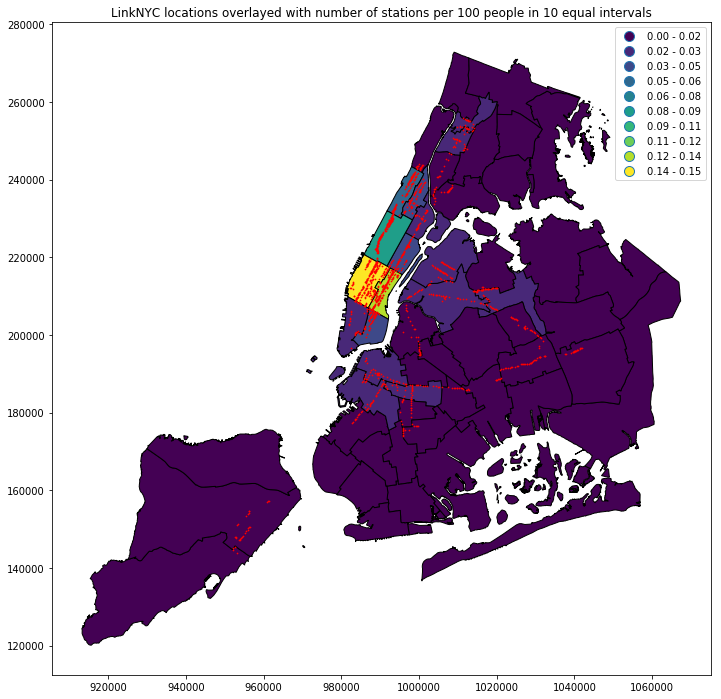

In [109]:
base = gdf.plot(column="linkp100", scheme="Equal_interval", k=10, legend=True, figsize=(12,12), edgecolor="black")
linknyc.plot(ax=base, marker=".", color="red", markersize=2)
base.set_title("LinkNYC locations overlayed with number of stations per 100 people in 10 equal intervals")

#### Figure 4: LinkNYC locations as red points, overlayed on a choropleth colored by 10 equal intervals representing number of stations per 100 people